In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

To get everything in a notebook.

In [ ]:
from nb_007 import *

In [ ]:
PATH = Path('../data/cifar10/')
torch.backends.cudnn.benchmark = True

Model definition

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)

def ResizeBatch(*size): return Lambda(lambda x: x.view((-1,)+size))
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))
def PoolFlatten(): return nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten())

In [ ]:
def conv_2d(ni, nf, ks, stride): return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn(ni, init_zero=False):
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv_2d(ni, nf, ks, stride))

def noop(x): return x

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv_2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)


def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet(nn.Module):
    def __init__(self, num_groups, N, num_classes, k=1, drop_p=0.0, start_nf=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv_2d(3, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[3]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[3], num_classes)]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


def wrn_22(): return WideResNet(num_groups=3, N=3, num_classes=10, k=6, drop_p=0.)

In [ ]:
model = wrn_22()

This is the way to create datasets in fastai

In [ ]:
train_ds,valid_ds = ImageDataset.from_folder(PATH/'train'), ImageDataset.from_folder(PATH/'test')

In [ ]:
cifar_mean,cifar_std = map(tensor, ([0.4914, 0.48216, 0.44653], [0.24703, 0.24349, 0.26159]))
cifar_norm,cifar_denorm = normalize_funcs(cifar_mean,cifar_std)

In [ ]:
train_tfms = [pad(padding=4), 
              crop(size=32, row_pct=(0,1), col_pct=(0,1)), 
              flip_lr(p=0.5)]

In [ ]:
data = DataBunch.create(train_ds, valid_ds, bs=512, train_tfm=train_tfms, tfms=cifar_norm, num_workers=8)

A learner wraps together the data and the model, like in fastai. Here we test the usual training to 94% accuracy with AdamW.

In [ ]:
model = wrn_22()
learn = Learner(data, model)
learn.metrics = [accuracy]

warm up

In [ ]:
learn.fit_one_cycle(1, 3e-3, wd=0.4, div_factor=10)

Total time: 00:31
epoch  train loss  valid loss  accuracy
0      1.337065    1.082762    0.609500  (00:31)



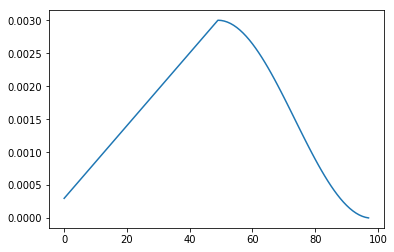

In [ ]:
learn.recorder.plot_lr()

## FP16

The same but in mixed-precision.

In [ ]:
model = wrn_22()
model = model2half(model)
learn = Learner(data, model)
learn.metrics = [accuracy]
learn.callbacks.append(MixedPrecision(learn))

In [ ]:
%time learn.fit_one_cycle(25, 3e-3, wd=0.4, div_factor=10)

Total time: 06:00
epoch  train loss  valid loss  accuracy
0      1.430891    1.398491    0.501000  (00:14)
1      1.061705    0.986364    0.644000  (00:14)
2      0.838563    1.008399    0.657300  (00:14)
3      0.695539    0.791527    0.730300  (00:14)
4      0.605823    0.812625    0.732100  (00:14)
5      0.534148    0.623167    0.789800  (00:14)
6      0.496663    0.826545    0.736900  (00:14)
7      0.461931    0.654031    0.781400  (00:14)
8      0.441907    0.614082    0.799900  (00:14)
9      0.407904    0.626947    0.795200  (00:14)
10     0.390932    0.522992    0.826900  (00:14)
11     0.377011    0.682757    0.787800  (00:14)
12     0.361617    0.942910    0.721000  (00:14)
13     0.338757    0.722718    0.783000  (00:14)
14     0.314459    0.601760    0.812800  (00:14)
15     0.280130    0.491810    0.841900  (00:14)
16     0.254688    0.497176    0.845200  (00:14)
17     0.218617    0.348053    0.885900  (00:14)
18     0.188661    0.304984    0.899300  (00:14)
19     0.14

In [ ]:
%time learn.fit_one_cycle(30, 3e-3, wd=0.4, div_factor=10)

Total time: 07:11
epoch  train loss  valid loss  accuracy
0      1.393063    1.417441    0.493300  (00:17)
1      1.027538    1.088767    0.616700  (00:14)
2      0.836060    0.941692    0.683400  (00:14)
3      0.688142    0.690871    0.759500  (00:14)
4      0.594530    1.033483    0.675200  (00:14)
5      0.542689    0.816458    0.725300  (00:14)
6      0.498397    0.887681    0.721900  (00:14)
7      0.449883    0.661108    0.785300  (00:14)
8      0.434427    0.634441    0.786900  (00:14)
9      0.410082    0.609202    0.785200  (00:14)
10     0.380734    0.644742    0.794400  (00:14)
11     0.375207    0.616527    0.795500  (00:14)
12     0.364760    0.578489    0.805400  (00:14)
13     0.349154    0.496333    0.835500  (00:14)
14     0.338663    0.626630    0.794900  (00:14)
15     0.336282    0.674507    0.787300  (00:14)
16     0.307156    0.471588    0.835900  (00:14)
17     0.285396    0.436213    0.855200  (00:14)
18     0.262049    0.426600    0.853800  (00:14)
19     0.23